##***MODELO DE DETECCION Y CONTORNEO DE FIRMAS EN IMÁGENES DE DOCUMENTOS*** 
---
En este presente Colab lo que tratamos de construir es un modelo para detectar las firmas existentes de las fotogafías de los documentos 'Expedientes' y poder tener una mejor visualizacion, una vez identificada creamos un recuadro donde se aloja la firma en la imagen.
Para esto ocupamos **OpenCv** *(biblioteca libre de visión artificial)* y **Scikit-image** *(colección de algoritmos para el procesamiento de imágenes)*.

#Paso 1:
Importamos las imágenes desde nuestra carpeta en Drive para usarlo en el modelo.
      

In [ ]:
from google.colab import drive
drive.mount('/content/drive')
#4/1AX4XfWjuLcZ3Z5ifH8zcDp-ZPqc_GrhjQZ2uMetoG65xRfLuc3isOJM0WEs

Mounted at /content/drive


In [ ]:

in_dir= 'drive/MyDrive/Datos - Hackathon JusticIA/Expedientes'
def ls(ruta = getcwd()):
    return [abspath(arch.path) for arch in scandir(ruta) if arch.is_file()]
lista=ls(in_dir)
print(len(lista))

#Paso 2
Importamos las Librerias

In [ ]:
import cv2
import matplotlib.pyplot as plt
from skimage import measure, morphology
from skimage.color import label2rgb
from skimage.measure import regionprops
import numpy as np
import sklearn
import scipy 
import math
import  PIL
from PIL import Image 
import pandas as pd
from os import scandir, getcwd
from os.path import abspath
import os
import numpy as np
import cv2
import imutils

6 768


#Paso 3
  Implementación del Modelo, *EXTRACCION Y CONTORNEO DE FIRMAS EN UNA IMAGEN BASADO EN EL ANÁLISIS DE COMPONENTES CONECTADOS*

  Para esta parte lo primero que hacemos es crear un ciclo para acceder a las imágenes de la carpeta.
>Idea del modelo
  >>PARTE 1: En esta primera parte aplicaremos el concepto de análisis de componentes conectados, aplicando distintos filtros y discriminando componentes pequeños conectados (letras, rayones, etc.), nos quedamos con los componentes mas grandes conectados, en este caso las *firmas*, dándonos como resultado una imagen binaria donde solo se muestra el fondo blanco y los componentes conectados (firmas) en color negro.

  >>PARTE 2: Para la ultima parte recibimos la imagen umbralizada de la primera parte, en esta buscamos los contornos y los seleccionamos en rectángulos encerrando el área de las firmas. 
  >Finalmente guardamos las imágenes en un .csv para que se pueda descargar y visualizar.

  







In [ ]:
"""Extract signatures from an image."""
file = fileList[:900]
path = "/content/drive/MyDrive/Datos - Hackathon JusticIA/Expedientes"

t = 0
i = 0
for test in file:
    #PARTE 1
    ##píxeles conectados de tamaño pequeño
    constant_parameter_1 = 84
    constant_parameter_2 = 250
    constant_parameter_3 = 100
    #píxeles conectados de gran tamaño
    constant_parameter_4 = 18
    # read the img
    img = cv2.imread(test, 0)

    img = cv2.threshold(img, 127, 255, cv2.THRESH_BINARY)[1]  

    #Analisis de componentes conectados        
    blobs = img > img.mean()
    #Etiqueta las regiones conectadas de una matriz
    #nos devuelve una matriz etiquetada, donde a todas las regiones conectadas se les asigna el mismo valor entero.
    blobs_labels = measure.label(blobs, background=1)  
    #Devuelve una imagen RGB donde se pintan etiquetas codificadas por colores sobre la imagen.
    image_label_overlay = label2rgb(blobs_labels, image=img)
    #
    fig, ax = plt.subplots(figsize=(10, 6)) #nro col, nro fil
    #Inicializamos parámetros iniciales
    the_biggest_component = 0
    total_area = 0
    counter = 0
    average = 0.0
    #
    for region in regionprops(blobs_labels):
        if (region.area > 10):
            total_area = total_area + region.area
            counter = counter + 1
            
        #toma las regiones con áreas suficientemente grandes
        if (region.area >= 250):
            if (region.area > the_biggest_component):
                the_biggest_component = region.area

    #sacamos la media de la áreas pequeñas y el componente más grande lo ponemos en the_bigest_component
    average = (total_area/counter)   

    #calulamos las proporciones de la áres
    # se utiliza como valor umbral para eliminar los píxeles conectados más pequeños, tambien para documentos grandes como el a4
    a4_small_size_outliar_constant = ((average/constant_parameter_1)*constant_parameter_2)+constant_parameter_3    
    # cálculo de la relación
    # se utiliza como valor umbral para eliminar los píxeles conectados más granes,
    a4_big_size_outliar_constant = a4_small_size_outliar_constant*constant_parameter_4   

    # eliminar los píxeles conectados son más pequeños que a4_small_siz...
    pre_version = morphology.remove_small_objects(blobs_labels, a4_small_size_outliar_constant)
    # eliminar los píxeles conectados son más grandes que a4_big_siz...
    #para deshacerse de los píxeles conectados no deseados, como las cabeceras de las tablas, etc
    component_sizes = np.bincount(pre_version.ravel())
    too_small = component_sizes > (a4_big_size_outliar_constant)
    too_small_mask = too_small[pre_version]
    pre_version[too_small_mask] = 0
    # guardamos la pre version
    #como considerando componentes conectados
    cv2.imwrite('pre_version.png', pre_version)    
    img = cv2.imread('pre_version.png', 0)    
    #Aplicamos nuevamente umbralizaxcion binario inversa
    img = cv2.threshold(img, 0, 255, cv2.THRESH_BINARY_INV | cv2.THRESH_OTSU)[1]
    #fin mmodelo de deteccion de firma
    #PARTE 2
    #recuadro de la firma 
    #preguntamos si la imagen no esta vacía    
    if img  is None:      
      continue
    else:
      #guardamos la imagen
      #cv2.imwrite("./outputs/output.png", img)     

      # cargar la imagen, convertirla a escala de grises y difuminarla para eliminar el ruido
      image = img
      test_img_h, test_img_w, test_img_ch = np.array(img).shape
      #convertirlo a escala de grises
      gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
      gray = cv2.GaussianBlur(gray, (7, 7), 0)

      # aplicamos umbralizacion
      ret,thresh1 = cv2.threshold(gray ,127,255,cv2.THRESH_BINARY_INV)

      # dilatar las porciones blancas
      dilate = cv2.dilate(thresh1, None, iterations=2)

      # buscamos contornos de la imagen
      cnts = cv2.findContours(dilate.copy(), cv2.RETR_EXTERNAL,
          cv2.CHAIN_APPROX_SIMPLE)

      cnts = cnts[0] 
      #creamos una copia de la imagen
      orig = image.copy()      
      y = 1
      for cnt in cnts:
          #Comprueba el área del contorno, si es muy pequeña la igonoramos
          if y < 15:
            #Comprueba el área del contorno, si es muy pequeña la igonoramos
            if(cv2.contourArea(cnt) < 100):
                continue

            # filtramos los contornos de la imagen
            x,y,w,h = cv2.boundingRect(cnt)

            # tomamos la region de interes de los contonos como rectangulo
            roi = image[y:y+h, x:x+w]
            #imagen final
            roi = cv2.rectangle(orig,(x,y),(x+w,y+h),(0,255,0),2)        
         
            # Save your contours or characters
            cv2.imwrite("roi" + str(i) + ".png", roi)
            #print('i: ',i)
            pic_narray = np.array(roi)
            listanames.append(roi)
            listawidth.append(test_img_w)
            listaheight.append(test_img_h)
            listaxmin.append(x)
            listaymin.append(y)
            listaxmax.append(x+w)
            listaymax.append(y+h)
            listaetiqueta.append("Signature")
            i = i + 1      
            y = y +6
          else:        
            break
          

In [ ]:
datafiles = {'filename':listanames, 'width':listawidth, 'height': listaheight, 'etiqueta':listaetiqueta, 'xmin':listaxmin, 'ymin':listaymin, 'xmax':listaxmax, 'ymax':listaymax}

#PASO 4
Guardamos las imágenes en un dataframe y lo exportamos en un .csv

In [ ]:
dffiles= pd.DataFrame(datafiles)
dffiles

,filename,width,height,etiqueta,xmin,ymin,xmax,ymax
0,"[[[255, 255, 255], [255, 255, 255], [255, 255,...",389,491,Signature,191,431,209,440
1,"[[[255, 255, 255], [255, 255, 255], [255, 255,...",389,491,Signature,182,417,242,430
2,"[[[255, 255, 255], [255, 255, 255], [255, 255,...",389,491,Signature,342,234,360,242


In [ ]:
#print(dffiles.index)
dffiles.to_csv (r'/export_dataframe.csv', index = False, header=True)

[[[255 255 255]
  [255 255 255]
  [255 255 255]
  ...
  [255 255 255]
  [255 255 255]
  [255 255 255]]

 [[255 255 255]
  [255 255 255]
  [255 255 255]
  ...
  [255 255 255]
  [255 255 255]
  [255 255 255]]

 [[255 255 255]
  [255 255 255]
  [255 255 255]
  ...
  [255 255 255]
  [255 255 255]
  [255 255 255]]

 ...

 [[255 255 255]
  [255 255 255]
  [255 255 255]
  ...
  [255 255 255]
  [255 255 255]
  [255 255 255]]

 [[255 255 255]
  [255 255 255]
  [255 255 255]
  ...
  [255 255 255]
  [255 255 255]
  [255 255 255]]

 [[255 255 255]
  [255 255 255]
  [255 255 255]
  ...
  [255 255 255]
  [255 255 255]
  [255 255 255]]]


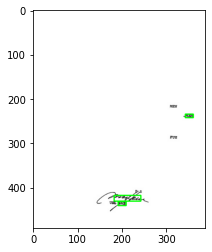

In [ ]:
#guardamos la imagen como array y lo convertimos para poder visualizar y/o modificar :)
#im0 = dffiles.iloc[0, 0]
#print(im0)
#data = Image.fromarray(im0)
#plt.imshow(data)